In [40]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
import keras.utils.np_utils as kutils
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline 

In [5]:
# read train.csv and prepare train data/labels out of it
train_csv = pd.read_csv("./train.csv")
print(train_csv.shape)
train_csv.head(1)

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
ROWS = 28
COLS = 28

# reshape flat data into (nCount,row,col,nChannel)
#train = train_csv.values[:, 1:].reshape(train_csv.shape[0], ROWS, COLS, 1)
train = train_csv.values[:1000, 1:].reshape(1000, ROWS, COLS, 1)
train = train.astype(float)
train /= 255.0

# prepare train labels as one-hot encoding style
#labels = kutils.to_categorical(train_csv.values[:, 0])
labels = kutils.to_categorical(train_csv.values[:1000, 0])
nClasses = labels.shape[1]

print('Train shape: {}'.format(train.shape))
print('Label shape: {}'.format(labels.shape))
print('number of classes: {}'.format(nClasses))

Train shape: (1000, 28, 28, 1)
Label shape: (1000, 10)
number of classes: 10


In [33]:
# CNN model
model = models.Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', activation="relu", input_shape=(ROWS,COLS,1)))
model.add(Convolution2D(32, 3, 3, border_mode='same', activation="relu"))
model.add(MaxPooling2D(strides=(2, 2)))
# (None, 32, ROWS/2, COLS/2)

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(strides=(2,2)))
# (None, 64, ROWS/4, COLS/4 )

#model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
#model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
#model.add(MaxPooling2D(strides=(2,2)))
# (None, 128, ROWS/8, COLS/8 )

model.add(Flatten())  # (None, ROWS*COLS)
model.add(Dense(256, activation='relu')) # (None, 256)
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu')) # (None, 256)
model.add(Dropout(0.5))
model.add(Dense(nClasses)) # (None, 10)
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_45 (Convolution2D) (None, 28, 28, 32)    320         convolution2d_input_10[0][0]     
____________________________________________________________________________________________________
convolution2d_46 (Convolution2D) (None, 28, 28, 32)    9248        convolution2d_45[0][0]           
____________________________________________________________________________________________________
maxpooling2d_23 (MaxPooling2D)   (None, 14, 14, 32)    0           convolution2d_46[0][0]           
____________________________________________________________________________________________________
convolution2d_47 (Convolution2D) (None, 14, 14, 64)    18496       maxpooling2d_23[0][0]            
___________________________________________________________________________________________

In [49]:
nb_epoch = 10

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
history = LossHistory()

model.fit(train, labels, batch_size=128, nb_epoch=nb_epoch,
          validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])

Train on 750 samples, validate on 250 samples
Epoch 1/10
750/750 [==============================] - 7s - loss: 0.9196 - acc: 0.6747 - val_loss: 0.5686 - val_acc: 0.8000
Epoch 2/10
750/750 [==============================] - 6s - loss: 0.7426 - acc: 0.7427 - val_loss: 0.4313 - val_acc: 0.8480
Epoch 3/10
750/750 [==============================] - 6s - loss: 0.6142 - acc: 0.7907 - val_loss: 0.4189 - val_acc: 0.8600
Epoch 4/10
750/750 [==============================] - 6s - loss: 0.5359 - acc: 0.8187 - val_loss: 0.3351 - val_acc: 0.8960
Epoch 5/10
750/750 [==============================] - 6s - loss: 0.5146 - acc: 0.8360 - val_loss: 0.2862 - val_acc: 0.9120
Epoch 6/10
750/750 [==============================] - 6s - loss: 0.3923 - acc: 0.8747 - val_loss: 0.2989 - val_acc: 0.9120
Epoch 7/10
750/750 [==============================] - 6s - loss: 0.3396 - acc: 0.8920 - val_loss: 0.2586 - val_acc: 0.9280
Epoch 8/10
750/750 [==============================] - 7s - loss: 0.2798 - acc: 0.9280 - val_l

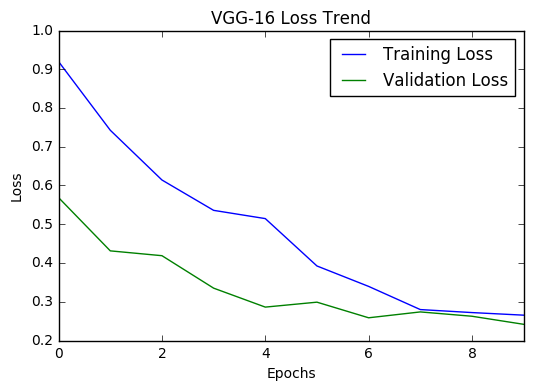

In [50]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [52]:
# prepare test data
test_csv = pd.read_csv("./test.csv")
test = test_csv.values.reshape(test_csv.shape[0], ROWS, COLS, 1)
test = test.astype(float)
test /= 255.0

test_labels = model.predict_classes(test)
np.savetxt("submission.csv", np.c_[range(1,len(test_labels)+1),test_labels], delimiter=',',
          header = 'ImageId,Label',comments='',fmt='%d')


28000/28000 [==============================] - 86s    
